In [1]:
import datetime
import QuantLib as ql
import QuantExt as qe
from SWAP_CURVE_hb import GET_QUOTE, SWAP_CURVE

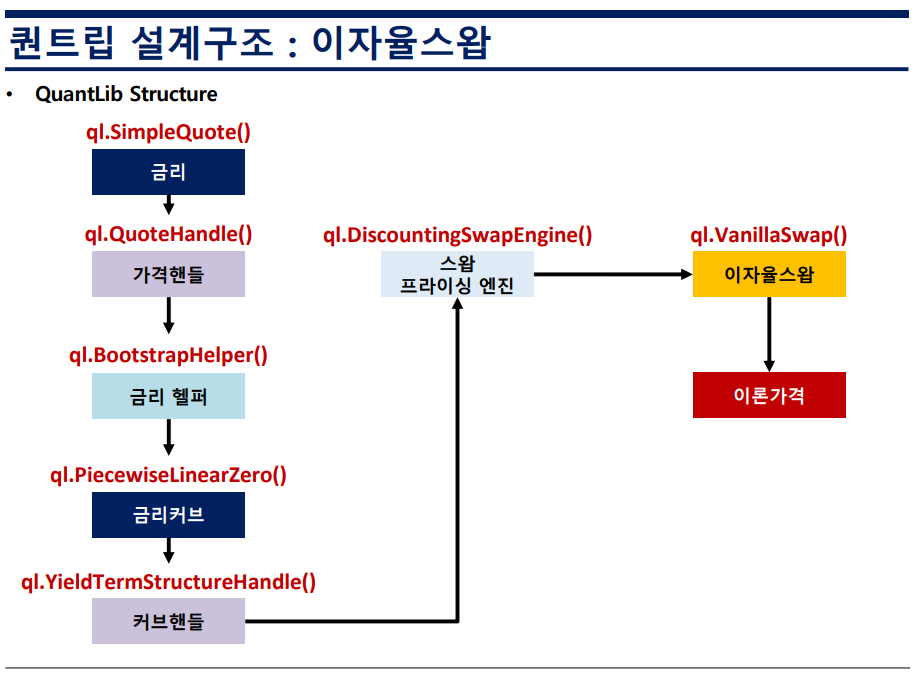

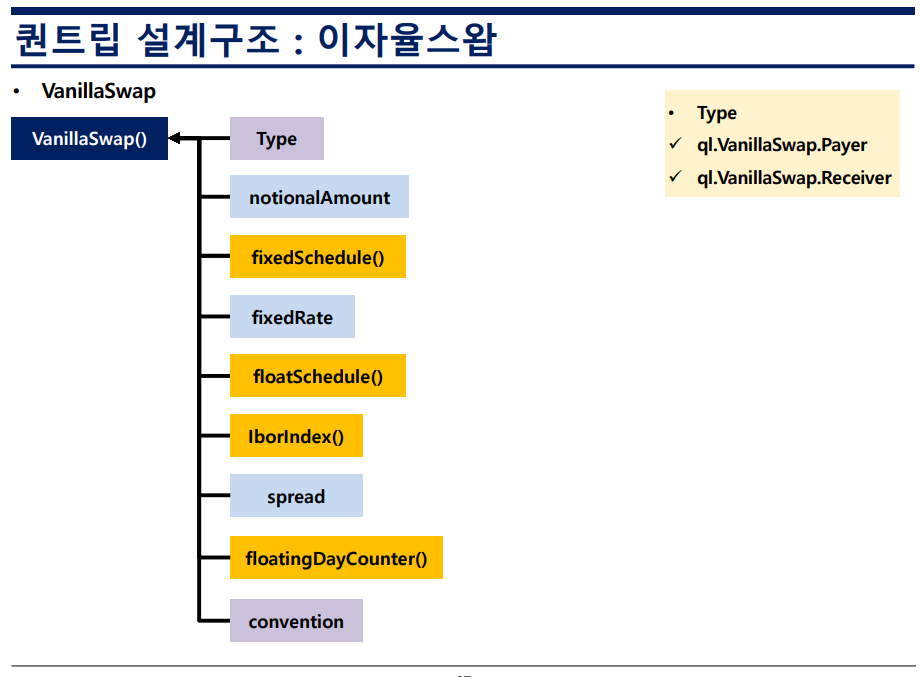

In [7]:
class IRS():
    def __init__(self, todays_date, effective_date, maturity_date, irs_rate, notional, position, spread=0.0):
        
        self.date = todays_date
        self.curve = self.CURVE(self.date)
        
        self.effective_date = ql.Date(effective_date.day, effective_date.month, effective_date.year)
        self.maturity_date = ql.Date(maturity_date.day, maturity_date.month, maturity_date.year)
        self.calendar = ql.UnitedStates()
        self.convention = ql.ModifiedFollowing
        self.day_counter = ql.Actual360()
        
        #USD IRS의 고정금리는 1년마다 이자지급
        self.fixed_tenor = ql.Period(1, ql.Years)
        #변동금리는 3개월
        self.float_tenor = ql.Period(3, ql.Months)
        
        self.irs_rate = irs_rate
        self.notional = notional
        self.spread = spread
        
        if position == 'Long':
            self.position = ql.VanillaSwap.Payer
        elif position == 'Short':
            self.position = ql.VanillaSwap.Receiver
            
        self.npv = self.PRICING(self.curve)
        self.delta = self.DELTA()
        self.theta = self.THETA()
        
    def CURVE(self, date):
        #PiecewiseLinearZero()인 금리커브까지 만든 것
        return SWAP_CURVE(date, GET_QUOTE(date))
    
    def PRICING(self, curve):
        # Curve handle
        curve_handle = ql.YieldTermStructureHandle(curve)
        
        usd_3m_libor = ql.USDLibor(ql.Period(3, ql.Months),
                                  curve_handle)
        usd_3m_libor.addFixing(ql.Date(9,10,2020), 0.0022538) #임시로
        #us_3m_libor.addFixing(ql.date(9,4,2021), xxxx)
        
        fixedSchedule = ql.Schedule(self.effective_date,
                                   self.maturity_date,
                                   self.fixed_tenor,
                                   self.calendar,
                                   self.convention,
                                   self.convention,
                                   ql.DateGeneration.Backward,
                                   False)
        
        floatSchedule = ql.Schedule(self.effective_date,
                                   self.maturity_date,
                                   self.float_tenor,
                                   self.calendar,
                                   self.convention,
                                   self.convention,
                                   ql.DateGeneration.Backward,
                                   False)
        
        irs = ql.VanillaSwap(self.position,
                            self.notional,
                            fixedSchedule,
                            self.irs_rate,
                            self.day_counter,
                            floatSchedule,
                            usd_3m_libor,
                            self.spread,
                            self.day_counter)
        
        #Pricing Engine
        swapEngine = ql.DiscountingSwapEngine(curve_handle)
        irs.setPricingEngine(swapEngine)
        npv = irs.NPV()
        
        return npv
    
    def DELTA(self):
        curve_handle = ql.YieldTermStructureHandle(self.curve)
        basis_point = 0.0001
        up_curve = ql.ZeroSpreadedTermStructure(curve_handle,
                                               ql.QuoteHandle(ql.SimpleQuote(basis_point)))
        down_curve = ql.ZeroSpreadedTermStructure(curve_handle,
                                               ql.QuoteHandle(ql.SimpleQuote(-basis_point)))
        up_irs = self.PRICING(up_curve)
        down_irs = self.PRICING(down_curve)
        delta = (up_irs - down_irs)/2
        return delta
        
    def THETA(self):
        price_t0 = self.PRICING(self.CURVE(self.date))
        price_t1 = self.PRICING(self.CURVE(self.date + datetime.timedelta(days=1)))
        
        theta = price_t1 - price_t0
        return theta
    
if __name__ == '__main__':
    todays_date = datetime.date(2020,10,9)  #거래일 / 첫번째 변동금리 이날 정해줘야함 / 그래서 오류나는거
    
    try: 
        #효력발생일 = (거래일+2일) = (변동금리결정일 + 2일)
        # 거래일에 고정금리 fix하고 첫번째 변동금리도 결정함
        #변동금리 Fixing날짜를 효력발생일 or 정산일 2일전에 그때그때 지정해줘야함
        #에러가 나는 이유는 Lt0을 모르기 때문. 변동금리 얼마다~라고 지정안해줌 ㅠ
        #addFixing해주면 오류 안남
        effective_date = datetime.date(2020,10,13)   #거래일 + 2영업일
        maturity_date = datetime.date(2022,10,13)
    except:
        #효력발생일 = (거래일+2일) = (금리결정일 + 2일)
        #여기는 아예 미래이므로 fixing을 해줄 필요가 없음
        #그냥 시장금리커브로 추정함. 17일날 금리는 이럴것이다~
        effective_date = datetime.date(2020,10,19) # 19일로 가면, 17일이 거래일이 됨.
        maturity_date = datetime.date(2022,10,18)  # 9일날 거래를 하고 효력발생일이 19일이면 17일이 되면 17일 변동금리 fixing해줘야함
    position = 'Long' #금리가 1bp오르면 좋음. 
    irs_rate = 0.00218 #고정금리
    notional = 10000000 
    
    irs = IRS(todays_date, effective_date, maturity_date, irs_rate,
                  notional, position)
    print(f'price = {irs.npv}')
    print(f'delta = {irs.delta}')
    print(f'theta = {irs.theta}')

price = 64.20069885073463
delta = 1769.9293414873791
theta = 2.0285979389373097
